# Gradient Attack

In [ ]:
#-- INSTALLING THE NECESSARY PACKAGES
!pip install github-clone
!ghclone https://github.com/JonasGeiping/invertinggradients/tree/master/inversefed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'inversefed'...
done.


In [ ]:
#-- CLONNING FedML PROJECT AND EXTRACTING PACKAGES
!git clone https://github.com/shaoxiongji/federated-learning.git
!mv federated-learning/models models/
!mv federated-learning/utils utils/
!rm -rf federated-learning

Cloning into 'federated-learning'...
remote: Enumerating objects: 144, done.
remote: Total 144 (delta 0), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (144/144), 36.72 KiB | 12.24 MiB/s, done.
Resolving deltas: 100% (73/73), done.
mv: cannot move 'federated-learning/models' to 'models/models': Directory not empty
mv: cannot move 'federated-learning/utils' to 'utils/utils': Directory not empty


In [ ]:
# %%
#-- LIBRARIES

import ast
import random
import copy
from datetime import datetime

from PIL import Image

import numpy as np

import pandas as pd

import torch
from torch.optim import SGD
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision.models import resnet50
from torchvision.utils import make_grid
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, PILToTensor

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np

from google.colab import files

from models.Fed import FedAvg
from models.Update import LocalUpdate

import inversefed

In [ ]:
#-- DEFINING HELPER CLASS
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [ ]:
#-- SELECTING THE PROCESSOR
if torch.cuda.is_available():
  device = "cuda:0"
else:
  device = "cpu"

In [ ]:
#-- DEFINING DATASET MEAN AND SD
setup = inversefed.utils.system_startup()
dm = torch.as_tensor(inversefed.consts.cifar10_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.cifar10_std, **setup)[:, None, None]

Currently evaluating -------------------------------:
Wednesday, 13. July 2022 08:54AM
CPUs: 1, GPUs: 1 on dbeeef7ce46e.
GPU : Tesla T4


In [ ]:
#-- DEFINING NUMBER OF IMAGES IN THE BATCH
num_images = 1

## Defining Methods

In [ ]:
#-- DEFINE METHOD TO SET GROUP NORMALIZATION
def bn_to_gn(layer, num_groups):
    for name, _ in layer.named_modules():
        if name:
            try:
                sub_layer = getattr(layer, name)
                if isinstance(sub_layer, nn.BatchNorm2d):
                    num_channels = sub_layer.num_features
                    layer._modules[name] = nn.GroupNorm(num_groups, num_channels)
            except AttributeError:
                name = name.split('.')[0]
                sub_layer = getattr(layer, name)
                sub_layer = bn_to_gn(sub_layer, num_groups)
                layer.__setattr__(name=name, value=sub_layer)
    return layer

## Loading Image


In [ ]:
#-- LOADING IMAGE
!gdown 1rUBx1VPFfB9p8VR0lXQm_cPLJBxE70Y2
!gdown 1TU6B7UQ4dmMPsSeBIbd09DEhcXaClYJW
!gdown 1O99W5yA4gR5nAXi4qcJ6yEfxeIxyoqOz
!gdown 1gY2CnZorziGJ__nph3au-35Aie5plhkl
!gdown 1BbHOWdADOBB9heXsx9Zm-jiho3IaVUZk

image = Image.open('cat.png')

transform = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))
])

img_tensor = transform(image)

Downloading...
From: https://drive.google.com/uc?id=1rUBx1VPFfB9p8VR0lXQm_cPLJBxE70Y2
To: /content/car.jpeg
100% 7.83k/7.83k [00:00<00:00, 12.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TU6B7UQ4dmMPsSeBIbd09DEhcXaClYJW
To: /content/plane.jpeg
100% 4.81k/4.81k [00:00<00:00, 8.32MB/s]
Downloading...
From: https://drive.google.com/uc?id=1O99W5yA4gR5nAXi4qcJ6yEfxeIxyoqOz
To: /content/plane.png
100% 2.21k/2.21k [00:00<00:00, 4.39MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gY2CnZorziGJ__nph3au-35Aie5plhkl
To: /content/truck.png
100% 2.65k/2.65k [00:00<00:00, 5.26MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BbHOWdADOBB9heXsx9Zm-jiho3IaVUZk
To: /content/cat.png
100% 2.52k/2.52k [00:00<00:00, 4.75MB/s]


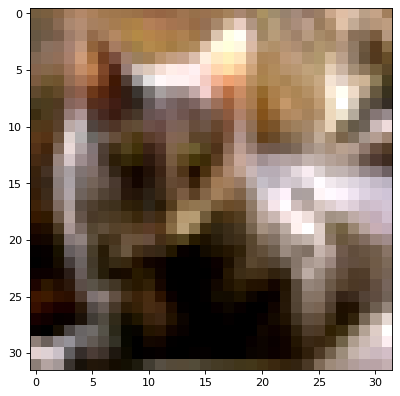

In [ ]:
from torch.functional import Tensor
#-- EXTRACTING BATCH
def show_images(images):
    images.mul_(ds).add_(dm).clamp_(0, 1)
    figure(figsize=(6, 6), dpi=80)
    images_cpu = make_grid(images, nrow=1).permute(1, 2, 0).cpu()
    plt.imshow(images_cpu.numpy())

images = [img_tensor.unsqueeze(0), torch.tensor(3).unsqueeze(0).type(torch.LongTensor)]
images[0] = images[0].to(device=device)
images[1] = images[1].to(device=device)
show_images(images[0])

In [ ]:
#-- DEFINING HYPERPARAMS AND MODEL
loss_fn = nn.CrossEntropyLoss()

model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet56", pretrained=True)
#model = resnet50(num_classes=10)
#bn_to_gn(model, 2) #Comment this to use BN
#num_images

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [ ]:
#-- LOADING THE NET
#!gdown 1tQ32ZYa1NCbJwrrpnkgz9e2HAeWxJsq9
#!gdown 1GC4qo98aW3ACNd6CoFqRNJW244YPl48I

#niid = 'fed-resnet50-niid-GN.txt'
#iid = 'fed-resnet50-iid-GN.txt'
#try:
#    model.load_state_dict(torch.load(iid)) # Change this to niid to run it with the niid model
#    print('Model loaded!')
#except:
#    pass

In [ ]:
#-- CREATING CONFIGURATION FOR RECONSTRUCTION ATTACK
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=0.01,
              optim='adam',
              restarts=2, # Increase to 4
              max_iterations=24_000, # Increase to 24_000
              total_variation=1e-1,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

In [ ]:
#-- ATTACKER
# Intercepts w_local and load the model
model.eval()
model.zero_grad()
model.to(device=device)
result = model(images[0])

# Calculates the gradient
target_loss = loss_fn(result, images[1])
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]

# Reconstruct the batch
rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=num_images)
output, stats = rec_machine.reconstruct(input_gradient, images[1], img_shape=(images[0].shape[1], images[0].shape[2], images[0].shape[3]))


It: 0. Rec. loss: 1.2166.
It: 500. Rec. loss: 0.8531.
Recovery interrupted manually in iteration 691!
Choosing optimal result ...
Optimal result score: 0.7383
Total time: 252.29373955726624.


Rec. loss: 0.7383 | MSE: 0.4813 | PSNR: 3.18 | FMSE: 6.4434e+00 |


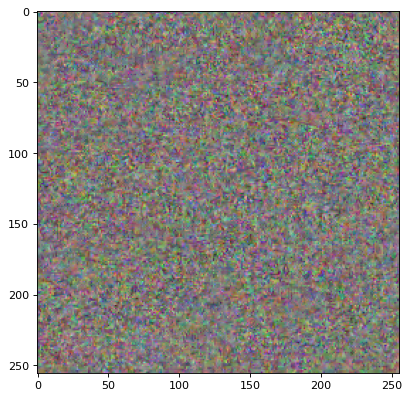

In [ ]:
#-- PRINTING THE RESULTS
test_mse = (output.detach() - images[0]).pow(2).mean()
feat_mse = (model(output.detach())- model(images[0])).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, images[0])

print(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |")

show_images(output)